[2025/02/18 18:27:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\LogaSanjeev/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\LogaSanjeev/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', re

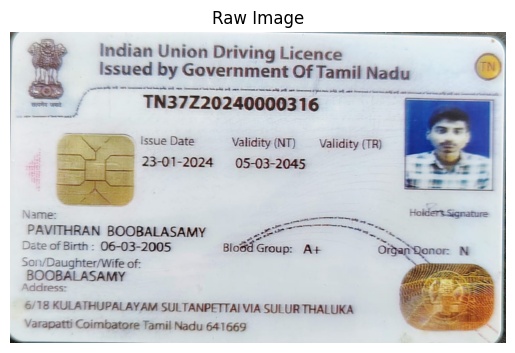

In [17]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import PaddleOCR

# Define class names
CLASS_NAMES = [
    "Address", "Blood Group", "DL No", "DOB", "Name", 
    "Relation With", "RTO", "State", "Vehicle Type"
]

# Load YOLO model
model = YOLO("./drivingLicence_Annotations.pt")   

ocr = PaddleOCR(use_angle_cls=True, lang="en")  # Change "en" if needed

# Run inference
image_path = "./Driving_Licence_Front.jpg"
results = model(image_path)

# Process results
filtered_boxes = {}
output_image = results[0].orig_img.copy()  # For visualization
original_image = cv2.imread(image_path)  # Original image for text extraction
h, w, _ = output_image.shape

# Display raw image
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Raw Image')
plt.show()

[2025/02/18 18:27:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.30612683296203613
[2025/02/18 18:27:18] ppocr DEBUG: cls num  : 1, elapsed : 0.019355297088623047
[2025/02/18 18:27:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11168289184570312
[2025/02/18 18:27:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.23058700561523438
[2025/02/18 18:27:19] ppocr DEBUG: cls num  : 1, elapsed : 0.013192176818847656
[2025/02/18 18:27:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07151508331298828
[2025/02/18 18:27:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2278602123260498
[2025/02/18 18:27:20] ppocr DEBUG: cls num  : 1, elapsed : 0.013999462127685547
[2025/02/18 18:27:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08491134643554688
[2025/02/18 18:27:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.2283000946044922
[2025/02/18 18:27:21] ppocr DEBUG: cls num  : 1, elapsed : 0.011599302291870117
[2025/02/18 18:27:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08112621307373047
[2025/02/18 18:27:

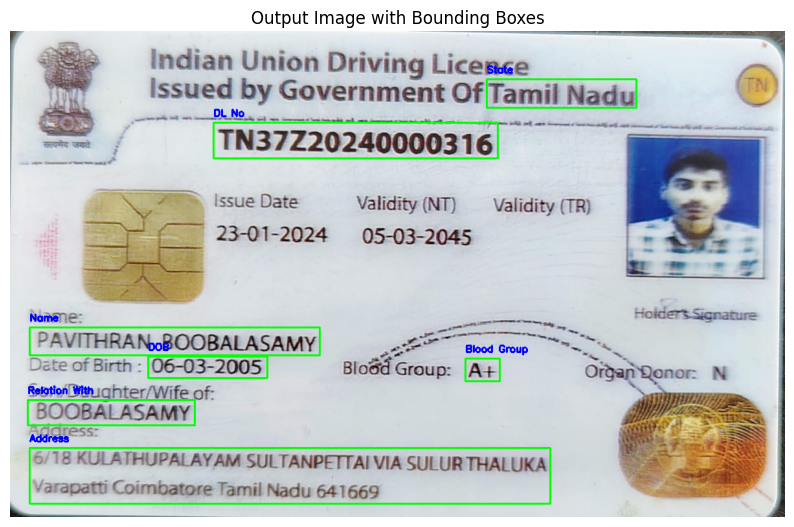

In [18]:
# Filter out detections, keeping the highest confidence box for each class
for result in results:
    for box in result.boxes:
        cls = int(box.cls[0].item())
        conf = box.conf[0].item()
        xyxy = box.xyxy[0].tolist()

        if cls not in filtered_boxes or conf > filtered_boxes[cls]['conf']:
            filtered_boxes[cls] = {"conf": conf, "xyxy": xyxy, "class_name": CLASS_NAMES[cls]}

# Initialize dictionary for extracted text
detected_text = {}

# List to store processed images for display later
processed_images = []

def upscale_image(image, scale=2):
    """Upscales the image to improve OCR accuracy."""
    return cv2.resize(image, (image.shape[1] * scale, image.shape[0] * scale), interpolation=cv2.INTER_CUBIC)

def unblur_image(image):
    """Sharpens the image to reduce blurriness."""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    return cv2.filter2D(image, -1, kernel)

def denoise_image(image):
    """Removes noise using Non-Local Means Denoising."""
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def enhance_contrast(image):
    """Enhances contrast using CLAHE (Adaptive Histogram Equalization)."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)  # Split channels
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)  # Apply CLAHE to the L (lightness) channel
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)  # Merge back

def preprocess_image(image):
    """Applies all preprocessing steps to improve OCR accuracy."""
    if isinstance(image, str):  # If a file path is given, read the image
        image = cv2.imread(image)
    
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Invalid image input. Provide a valid file path or a numpy array.")

    image = upscale_image(image, scale=2)
    image = unblur_image(image)
    image = denoise_image(image)
    image = enhance_contrast(image)
    return image

# Process each bounding box:
for cls, data in filtered_boxes.items():
    x_min, y_min, x_max, y_max = map(int, data["xyxy"])
    class_name = data["class_name"]
    
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(w, x_max)
    y_max = min(h, y_max)

    # Crop the region from the original image
    region_img = original_image[y_min:y_max, x_min:x_max]

    region_img = preprocess_image(region_img)
    
    # Get region dimensions (will remain unchanged)
    region_h, region_w = region_img.shape[:2]
    
    # Create a pitch black canvas with the same size as the original image
    black_canvas = np.ones((h, w, 3), dtype=np.uint8)
    
    # Compute coordinates to place the region at the center of the black canvas
    center_x = w // 2
    center_y = h // 2
    top_left_x = center_x - region_w // 2
    top_left_y = center_y - region_h // 2

    # Ensure the placement coordinates do not exceed image bounds
    top_left_x = max(0, min(w - region_w, top_left_x))
    top_left_y = max(0, min(h - region_h, top_left_y))

    # Resize region_img if necessary to fit within the available space
    region_w = min(region_w, w - top_left_x)
    region_h = min(region_h, h - top_left_y)
    region_img = cv2.resize(region_img, (region_w, region_h))

    # Place the cropped region onto the black canvas
    black_canvas[top_left_y:top_left_y+region_h, top_left_x:top_left_x+region_w] = region_img

    # Perform OCR using PaddleOCR on the preprocessed image
    result = ocr.ocr(black_canvas, cls=True)
    if result is None:
        result = []
    
    # Extract text from the OCR results
    extracted_text = " ".join(
        [word_info[1][0] for line in result if line for word_info in line if word_info]
    )
    detected_text[class_name] = extracted_text

    # For visualization: draw OCR bounding boxes on the image
    for line in result:
        if line is None:
            continue
        for word_info in line:
            if word_info is None:
                continue
            box = word_info[0]
            x1, y1 = int(box[0][0]), int(box[0][1])
            x2, y2 = int(box[2][0]), int(box[2][1])
            cv2.rectangle(black_canvas, (x1, y1), (x2, y2), (0, 255, 0), 5)
    
    # Save the processed image for display later
    processed_images.append((class_name, black_canvas, extracted_text))
    
    # Optionally, draw the original bounding box and class name on the output image for visualization
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(output_image, class_name, (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Save the detected text to a JSON file
with open("detected_text.json", "w") as json_file:
    json.dump(detected_text, json_file, indent=4)

# Display the output image with the original bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Output Image with Bounding Boxes")
plt.show()

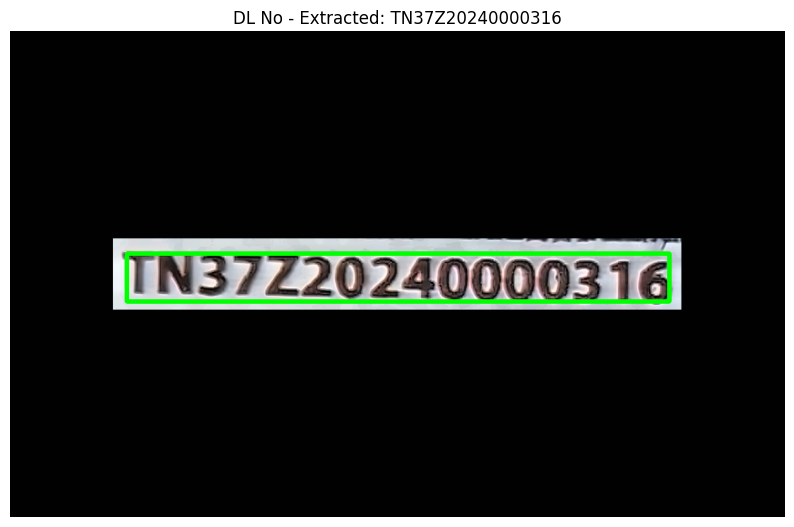

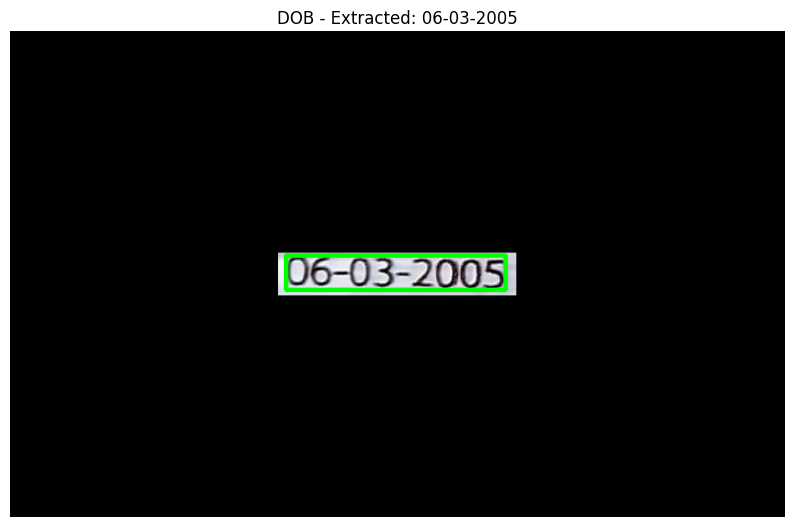

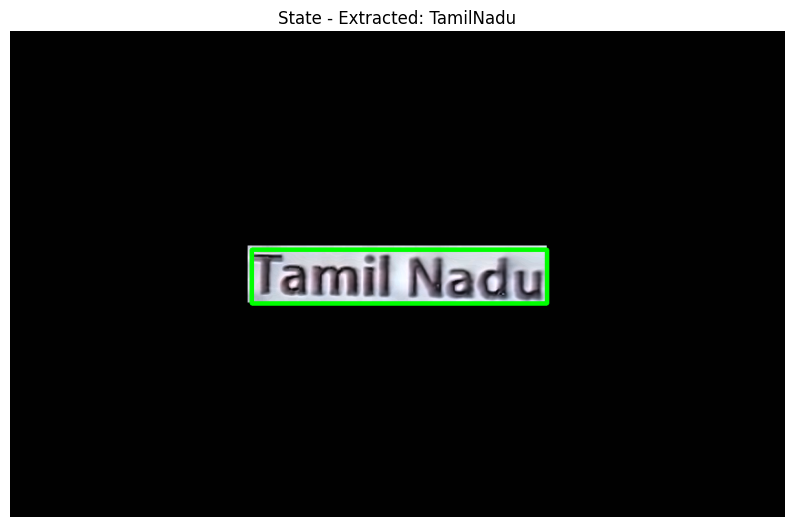

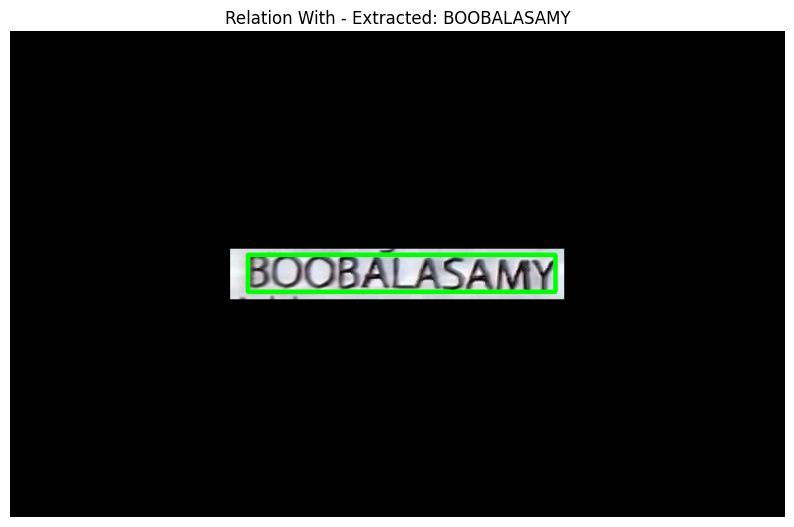

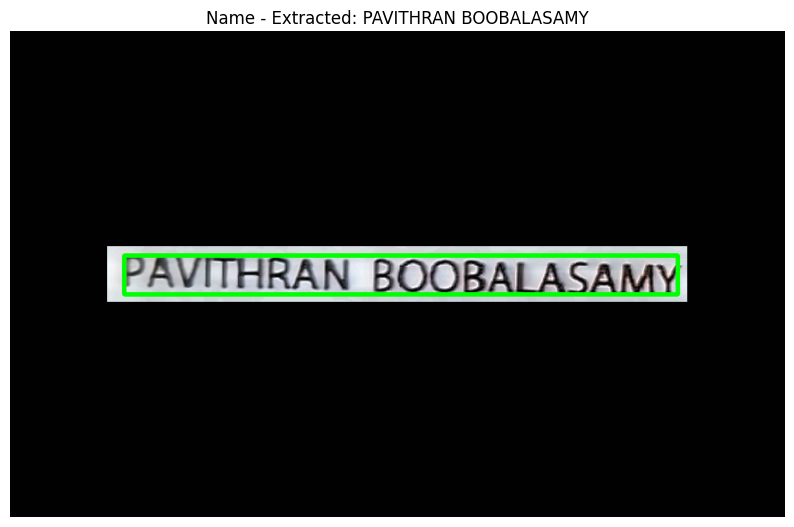

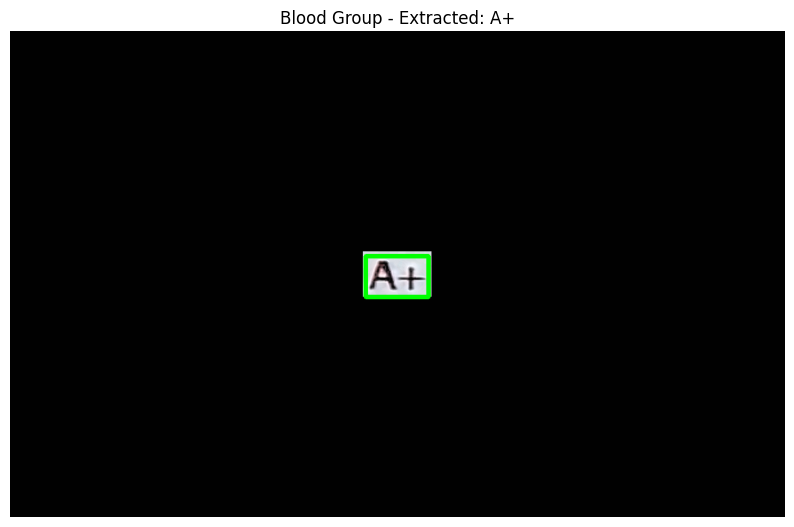

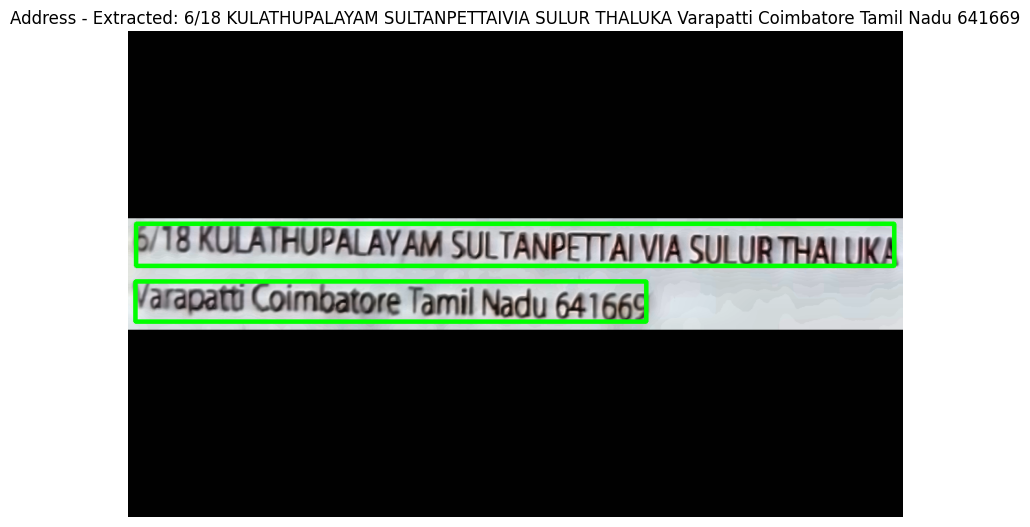

Text extracted and saved to detected_text.json.


In [19]:
# Display cropped images with bounding boxes
for class_name, cropped_image, text in processed_images:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{class_name} - Extracted: {text}")
    plt.show()

print("Text extracted and saved to detected_text.json.")